In [13]:
#!/cvmfs/soft.computecanada.ca/easybuild/software/2017/Core/python/3.5.4/bin/python

import netCDF4 as nc4
import numpy as np
import time
import pandas as pd
import os
import xarray as xr
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
secprday = 3600*24


In [15]:
# select reservoir name
reservoir_name = 'Dickson' # possible to replace by: Dickson, Bhumiboi, Waterton, Glen_canyon, Palisades, Trinity, Semione, Sirikit
#reservoir_name = "Bhumiboi"
#reservoir_name = "Sirikit"
#reservoir_name = 'Waterton'

In [16]:
# Load data from Yassin et al 2019
metadata = pd.read_csv('observations/reservoirs_metadata.csv')
metadata.index = metadata['name']

# get the information
purpose = metadata.loc[reservoir_name].purpose
max_storage = metadata.loc[reservoir_name].capacity_mcm*10**6


# load observations
fn = 'observations/res_info_out_'+reservoir_name+'.csv'
df = pd.read_csv(fn)
df.index = pd.to_datetime(df.timed)
df['demand'] = 0 # there are currently no demand observations. Paste calculated demand in here

time_unit_nc = "days since "+str(pd.to_datetime(df.timed.iloc[0]))
print(time_unit_nc)

outflow_obs = df['outflow']
storage_obs = df['stoobs']; 
storage_inital = storage_obs[0]; print(storage_inital)
inflow = df['inflow']


# average inflow (Hanasaki uses naturalised inflow)
# here taken as mean over whole observational period
mean_inflow = inflow.mean() # (m³/s)

mean_inflow_monthly = inflow.groupby([inflow.index.month]).mean() # to adjust for seasonal cycle (m³/s)
print(mean_inflow_monthly)

# 
demand_irrig_monthly = np.zeros(12) # [m³/s] 

if reservoir_name == "Bhumiboi": demand_irrig_monthly = np.array([0,150,200,250,200,75,50,50,20,0,30,0])
if reservoir_name == "Sirikit" : demand_irrig_monthly = np.array([0,50,100,200,100,50,20,50,10,10,0,0])
if reservoir_name == "Waterton": demand_irrig_monthly = np.array([0,0,5,30,50,50,30,20,5,0,0,0]) # estimated demand (to test demand > inflow * erf)


# interpolate estimated monthly demands to average day-of-year values and (demand is zero if non-irrigation reservoir)
interp = interp1d(np.linspace(0,11, num=12), demand_irrig_monthly, kind='cubic')
demand_irrig_doy = interp(np.linspace(0,11, num=366))

# assign daily demand based on corresponding day of year of mean year
for d in range(1,367):
    df.loc[df.index.dayofyear == d, 'demand'] = demand_irrig_doy[d-1]
demand = df.demand
    
# total annual inflow
mean_inflow_yearly = mean_inflow_monthly.mean() # m³/s
 
c = max_storage/(mean_inflow_yearly * secprday * 365) #[m³/yr] # if c>0.5 : large reservoir, if c < 0.5: "whitin-a-year" reservoir, if c = 0, reservoir is "run-of-the-river"

print('reservoir = '+reservoir_name)
print("purpose = "+purpose)
print("c = %.2f" %c)
print("mean annual inflow = %.0f m³/s" %mean_inflow_yearly)
print("maximum storage = %.0f m³" %max_storage)
print("initial storage = %.0f m³" %storage_inital)


days since 2005-01-01 00:00:00
182704096.125
timed
1       8.646143
2       8.588548
3       9.841558
4      18.645710
5      57.964023
6     132.582824
7      59.533733
8      41.274009
9      42.037962
10     27.566028
11     12.102624
12      9.800770
Name: inflow, dtype: float64
reservoir = Dickson
purpose = watersupply
c = 0.18
mean annual inflow = 36 m³/s
maximum storage = 203000000 m³
initial storage = 182704096 m³


In [17]:
# load the date frame and create the network topology
Ntopo = pd.read_csv('look_up/NetTopo.csv')
Ntopo_flags = pd.read_csv('look_up/NetTopo_flags.csv')


Ntopo.name.iloc[1] =  reservoir_name
Ntopo.H06_Smax     =  max_storage
Ntopo.H06_S_ini    =  storage_inital
Ntopo.name.iloc[1] =  reservoir_name
Ntopo.H06_I_Jan    =  mean_inflow_monthly.iloc[0]
Ntopo.H06_I_Feb    =  mean_inflow_monthly.iloc[1]
Ntopo.H06_I_Mar    =  mean_inflow_monthly.iloc[2]
Ntopo.H06_I_Apr    =  mean_inflow_monthly.iloc[3]
Ntopo.H06_I_May    =  mean_inflow_monthly.iloc[4]
Ntopo.H06_I_Jun    =  mean_inflow_monthly.iloc[5]
Ntopo.H06_I_Jul    =  mean_inflow_monthly.iloc[6]
Ntopo.H06_I_Aug    =  mean_inflow_monthly.iloc[7]
Ntopo.H06_I_Sep    =  mean_inflow_monthly.iloc[8]
Ntopo.H06_I_Oct    =  mean_inflow_monthly.iloc[9]
Ntopo.H06_I_Nov    =  mean_inflow_monthly.iloc[10]
Ntopo.H06_I_Dec    =  mean_inflow_monthly.iloc[11]
Ntopo.H06_D_Jan    =  demand_irrig_monthly[0]
Ntopo.H06_D_Feb    =  demand_irrig_monthly[1]
Ntopo.H06_D_Mar    =  demand_irrig_monthly[2]
Ntopo.H06_D_Apr    =  demand_irrig_monthly[3]
Ntopo.H06_D_May    =  demand_irrig_monthly[4]
Ntopo.H06_D_Jun    =  demand_irrig_monthly[5]
Ntopo.H06_D_Jul    =  demand_irrig_monthly[6]
Ntopo.H06_D_Aug    =  demand_irrig_monthly[7]
Ntopo.H06_D_Sep    =  demand_irrig_monthly[8]
Ntopo.H06_D_Oct    =  demand_irrig_monthly[9]
Ntopo.H06_D_Nov    =  demand_irrig_monthly[10]
Ntopo.H06_D_Dec    =  demand_irrig_monthly[11]

if purpose == "irrigation":
    Ntopo.purpose.iloc[1] = 1
else:
    Ntopo.purpose.iloc[1] = 0

Ntopo.to_csv('network_topology/NetTopo_'+reservoir_name+'.csv')


C:\Users\ivand\Anaconda3\envs\geopandas\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [18]:
# create the network topology file with parameters 

def nc_creation(Ntopo, Ntopo_flags, reservoir_name):
    
    # remove existing files
    if os.path.isfile('./network_topology/network_topology_'+reservoir_name+'.nc'):
        os.remove('./network_topology/network_topology_'+reservoir_name+'.nc')

    # open the nc file to write
    ncid = nc4.Dataset('./network_topology/network_topology_'+reservoir_name+'.nc', "w", format="NETCDF4")

    # the dimension of the nc file variables is equal to the row of the shapefile
    dimid_N = ncid.createDimension('n',Ntopo.shape[0])
    dimid_Nchar = ncid.createDimension('nchar',4)

    # going through the field one by one and saving them in nc varibales with long name, units and variable type (int, etc)
    for column in list(Ntopo_flags.columns):
        
        print(column, Ntopo_flags[column].iloc[0], Ntopo_flags[column].iloc[1], Ntopo_flags[column].iloc[2])
        
        # define the variable
        varid = ncid.createVariable(column, Ntopo_flags[column].iloc[0],('n',),\
                                    zlib=True,fill_value=Ntopo_flags[column].iloc[2]) #assuming all the fields are floats
        # Attributes
        varid.long_name      = column
        varid.unit           = Ntopo_flags[column].iloc[1]

        # Write data
        varid[:] = Ntopo[column]
    
    
    # define the variable PFAF
    varid = ncid.createVariable('PFAF','S1',('n','nchar',)) #assuming all the fields are floats
    # Attributes
    varid.long_name      = 'PFAF Order'
    varid.unit           = '-'
    # preparing the data
    data = np.full(Ntopo.shape[0], 'test', 'S4')
    data = nc4.stringtochar(data)
    varid[:,:]=data

    ncid.Conventions = 'CF-1.6'
    ncid.License     = 'The data were written by Shervan Gharari. They are under GPL.'
    ncid.history     = 'Created ' + time.ctime(time.time())
    ncid.source      = 'Written by test script of utilities (https://github.com/ShervanGharari/utility-codes).'
    ncid.close()


# 
nc_creation(Ntopo, Ntopo_flags, reservoir_name)





is_lake int - -1
lake_model int - -1
purpose int - -1
basin_area f8 m**2 -9999
length f8 m -9999
slope f8 - -9999
lon f8 - -9999
lat f8 - -9999
hruid int - -1
seg_id int - -1
seg_hr_id int - -1
tosegment int - -1
width f8 m -9999
manning f8 - -9999
H06_irrigation int - -1
H06_Smax f8 m**3 -9999
H06_alpha f8 - -9999
H06_envfact f8 - -9999
H06_S_ini f8 m**3 -9999
H06_C1 f8 - -9999
H06_C2 f8 - -9999
H06_power f8 - -9999
H06_dinominator f8 - -9999
H06_c_compare f8 - -9999
H06_dead_S_Per f8 - -9999
H06_I_Mem_F int - -1
H06_I_Mem_L int - -1
H06_D_Mem_F int - -1
H06_D_Mem_L int - -1
H06_I_Jan f8 m**3 s**-1 -9999
H06_I_Feb f8 m**3 s**-1 -9999
H06_I_Mar f8 m**3 s**-1 -9999
H06_I_Apr f8 m**3 s**-1 -9999
H06_I_May f8 m**3 s**-1 -9999
H06_I_Jun f8 m**3 s**-1 -9999
H06_I_Jul f8 m**3 s**-1 -9999
H06_I_Aug f8 m**3 s**-1 -9999
H06_I_Sep f8 m**3 s**-1 -9999
H06_I_Oct f8 m**3 s**-1 -9999
H06_I_Nov f8 m**3 s**-1 -9999
H06_I_Dec f8 m**3 s**-1 -9999
H06_D_Jan f8 m**3 s**-1 -9999
H06_D_Feb f8 m**3 s**-1 -99

In [19]:
# inspect created network topology file 
ds_nettopo = xr.open_dataset('./network_topology/network_topology_'+reservoir_name+'.nc')
ds_nettopo

<xarray.Dataset>
Dimensions:          (n: 3)
Dimensions without coordinates: n
Data variables:
    is_lake          (n) float64 ...
    lake_model       (n) float64 ...
    purpose          (n) float64 ...
    basin_area       (n) float64 ...
    length           (n) float64 ...
    slope            (n) float64 ...
    lon              (n) float64 ...
    lat              (n) float64 ...
    hruid            (n) float64 ...
    seg_id           (n) float64 ...
    seg_hr_id        (n) float64 ...
    tosegment        (n) float64 ...
    width            (n) float64 ...
    manning          (n) float64 ...
    H06_irrigation   (n) float64 ...
    H06_Smax         (n) float64 ...
    H06_alpha        (n) float64 ...
    H06_envfact      (n) float64 ...
    H06_S_ini        (n) float64 ...
    H06_C1           (n) float64 ...
    H06_C2           (n) float64 ...
    H06_power        (n) float64 ...
    H06_dinominator  (n) float64 ...
    H06_c_compare    (n) float64 ...
    H06_dead_S_Per   (n) float64 ...
    H06_I_Mem_F      (n) float64 ...
    H06_I_Mem_L      (n) float64 ...
    H06_D_Mem_F      (n) float64 ...
    H06_D_Mem_L      (n) float64 ...
    H06_I_Jan        (n) float64 ...
    H06_I_Feb        (n) float64 ...
    H06_I_Mar        (n) float64 ...
    H06_I_Apr        (n) float64 ...
    H06_I_May        (n) float64 ...
    H06_I_Jun        (n) float64 ...
    H06_I_Jul        (n) float64 ...
    H06_I_Aug        (n) float64 ...
    H06_I_Sep        (n) float64 ...
    H06_I_Oct        (n) float64 ...
    H06_I_Nov        (n) float64 ...
    H06_I_Dec        (n) float64 ...
    H06_D_Jan        (n) float64 ...
    H06_D_Feb        (n) float64 ...
    H06_D_Mar        (n) float64 ...
    H06_D_Apr        (n) float64 ...
    H06_D_May        (n) float64 ...
    H06_D_Jun        (n) float64 ...
    H06_D_Jul        (n) float64 ...
    H06_D_Aug        (n) float64 ...
    H06_D_Sep        (n) float64 ...
    H06_D_Oct        (n) float64 ...
    H06_D_Nov        (n) float64 ...
    H06_D_Dec        (n) float64 ...
    PFAF             (n) |S4 ...
Attributes:
    Conventions:  CF-1.6
    License:      The data were written by Shervan Gharari. They are under GPL.
    history:      Created Tue Feb 23 20:24:23 2021
    source:       Written by test script of utilities (https://github.com/She...

In [20]:
# create the input file for mizuRoute for a network topology of size 3

n_dim_length = 3
n_dim_time   = len(inflow)

print(n_dim_time, n_dim_length)

time_data = np.arange(n_dim_time)


# save inflow values as runoff
values_runoff = np.zeros((n_dim_time, n_dim_length))
values_runoff[:,0] = inflow

# save demand values (for reservoir ID)
values_demand = np.zeros((n_dim_time, n_dim_length))
values_demand[:,1] = demand



temp = pd.read_csv('network_topology/NetTopo_'+reservoir_name+'.csv')
basin_area = temp.basin_area.iloc[1]


if os.path.isfile('./network_topology/input_'+reservoir_name+'.nc'):
    os.remove('./network_topology/input_'+reservoir_name+'.nc')

with nc4.Dataset('./network_topology/input_'+reservoir_name+'.nc', "w", format="NETCDF4") as ncid:

    dimid_N = ncid.createDimension('n', n_dim_length)  # only write one variable
    dimid_T = ncid.createDimension('time', n_dim_time)

    # Variables
    time_varid = ncid.createVariable('time', 'i4', ('time', ))
    # Attributes
    time_varid.long_name = 'time'
    time_varid.units = time_unit_nc  # e.g. 'days since 1900-01-01 00:00'
    time_varid.calendar = 'gregorian'
    time_varid.standard_name = 'time'
    time_varid.axis = 'T'
    # Write data
    time_varid[:] = time_data

    # Variables
    ID_varid = ncid.createVariable('ID', 'int', ('n', ))
    # Attributes
    ID_varid.long_name = 'ID'
    ID_varid.units = '1'
    # Write data
    ID_varid[:] = np.array([1,2,3])

    # Variable
    # data_varid = ncid.createVariable(variable_name, 'f8', ('n','time', ), fill_value=-9999)
    data_varid = ncid.createVariable('runoff', 'f8', ('time','n', ), fill_value=-9999)
    # Attributes
    data_varid.long_name = 'runoff'
    data_varid.units = 'm day**-1'
    # Write data
    data_varid[:]   = values_runoff * secprday/ basin_area
    
    # Variable
    # data_varid = ncid.createVariable(variable_name, 'f8', ('n','time', ), fill_value=-9999)
    data_varid = ncid.createVariable('evapo', 'f8', ('time','n', ), fill_value=-9999)
    # Attributes
    data_varid.long_name = 'evaporation'
    data_varid.units = 'mm day**-1'
    # Write data
    data_varid[:] = 0
    
    # Variable
    # data_varid = ncid.createVariable(variable_name, 'f8', ('n','time', ), fill_value=-9999)
    data_varid = ncid.createVariable('precip', 'f8', ('time','n', ), fill_value=-9999)
    # Attributes
    data_varid.long_name = 'precipitation'
    data_varid.units = 'mm day**-1'
    # Write data
    data_varid[:] = 0

    # Variable
    # data_varid = ncid.createVariable(variable_name, 'f8', ('n','time', ), fill_value=-9999)
    data_varid = ncid.createVariable('demand', 'f8', ('time','n', ), fill_value=-9999)
    # Attributes
    data_varid.long_name = 'water demand'
    data_varid.units = 'mm day**-1'
    # Write data
    data_varid[:] = values_demand * secprday/ basin_area
    
    ##
    ncid.Conventions = 'CF-1.6'
    ncid.License = 'The data were written by Shervan Gharari. Under Apache2.'
    ncid.history = 'Created ' + time.ctime(time.time())
    ncid.source = 'Written by script from library of Shervan Gharari (https://github.com/ShervanGharari/candex).'



2556 3


[[0.00312768 0.         0.        ]
 [0.00549677 0.         0.        ]
 [0.00553133 0.         0.        ]
 ...
 [0.00672192 0.         0.        ]
 [0.00612576 0.         0.        ]
 [0.00558144 0.         0.        ]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


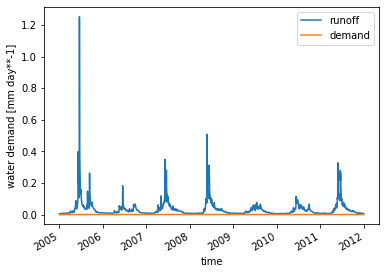

In [21]:
ds = xr.open_dataset('./network_topology/input_'+reservoir_name+'.nc')
ds.runoff[:,0].plot(label='runoff')
print(np.array(ds.runoff[:]))

ds.demand[:,1].plot(label='demand')
plt.legend()
print(np.array(ds.demand[:]))
